https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [1]:
# General Utility
import os
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from scipy import interp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [6]:
# Preprocessing
import missingno as msno
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [7]:
# Model Building
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [8]:
# Model Validation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [9]:
# Global
nb_seed = 1234

In [13]:
CSV_PATH = os.path.join('data', 'taiwan_cc', 'default_of_credit_card_clients.csv')
cc_raw = pd.read_csv(CSV_PATH, encoding='latin1', index_col='ID')
cc_target = cc_raw['default_payment_next_month'] 
display(cc_target.head())
cc_data = cc_raw.drop('default_payment_next_month', axis=1)
display(cc_data.head())

ID
1    1
2    1
3    0
4    0
5    0
Name: default_payment_next_month, dtype: int64

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
2,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [14]:
cc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 23 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
dtypes: int64(23)
memory usage: 5.5 MB


In [15]:
cc_raw.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_payment_next_month'],
      dtype='object')

**From the plot below, we see that there is a significant class imbalance between the populations that did and did not default. To counteract this imbalance, I'll explore over-sampling and under-sampling strategies to balance the class counts.**

**We also see an imbalance between the number of men and women in the study, but as gender isn't a target variable, I won't balance for gender. **

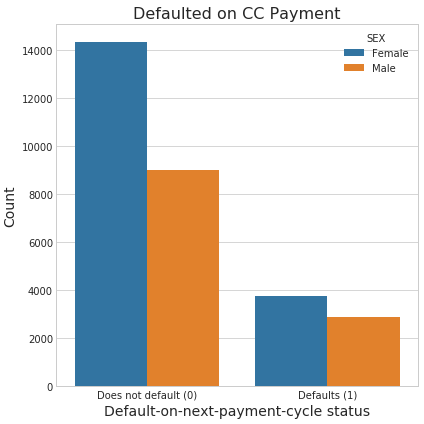

In [69]:
tmp = cc_raw[['default_payment_next_month','SEX']]
sex_dict = {1: 'Male', 2:'Female'}
tmp = tmp.replace({'SEX': sex_dict})

with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(6,6))
    sns.countplot(x='default_payment_next_month', hue='SEX', data=tmp, ax=ax)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax.set_xlabel('Default-on-next-payment-cycle status', fontsize=14)
    ax.set_title('Defaulted on CC Payment', fontsize=16)
    plt.tight_layout()

In [86]:
male_no_def = tmp[(tmp['SEX'] == 'Male') & (tmp['default_payment_next_month'] == 0)].count()[0]
female_no_def = tmp[(tmp['SEX'] == 'Female') & (tmp['default_payment_next_month'] == 0)].count()[0]
male_def = tmp[(tmp['SEX'] == 'Male') & (tmp['default_payment_next_month'] == 1)].count()[0]
female_def = tmp[(tmp['SEX'] == 'Female') & (tmp['default_payment_next_month'] == 1)].count()[0]

**We see that women were less likely to default on their credit.**

In [100]:
print('Males who didn\'t default: {:5d}, Females who didn\'t default: {:5d}'
      .format(male_no_def, female_no_def))
print('Males who did default: {:8d}, Females who did default: {:8d}'
      .format(male_def, female_def))
print('Percent of males who defaulted:   {:3.2f}%'.format(male_def*100/male_no_def))
print('Percent of females who defaulted: {:3.2f}%'.format(female_def*100/female_no_def))

Males who didn't default:  9015, Females who didn't default: 14349
Males who did default:     2873, Females who did default:     3763
Percent of males who defaulted:   31.87%
Percent of females who defaulted: 26.22%


**From the plot below, we see that several things.**
* **The third largest population completed high school,**
* **The plurality of the sampled population also went to university,**
* **The second largest population also completed grad school, and**
* **The remainder are either 'others' or in a column of 'unknown' values (these had values that weren't defined in the data description)**


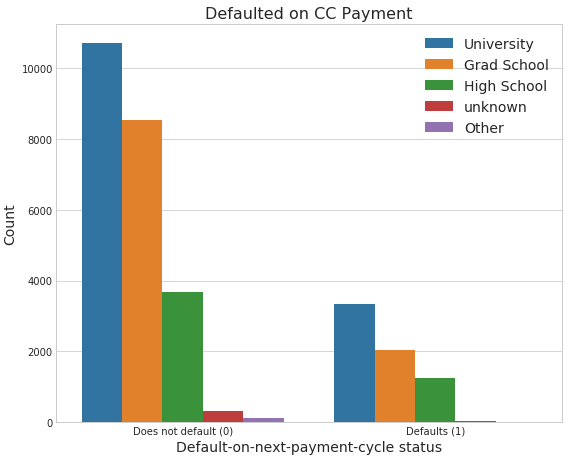

In [128]:
tmp = cc_raw[['default_payment_next_month','EDUCATION']]
edu_dict = {1:'Grad School',
            2:'University',
            3:'High School',
            4:'Other',
            5:'unknown',
            6:'unknown',
            0:'unknown'}
tmp = tmp.replace({'EDUCATION': edu_dict})

with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(8,6.5))
    sns.countplot(x='default_payment_next_month', hue='EDUCATION', data=tmp, ax=ax)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax.set_xlabel('Default-on-next-payment-cycle status', fontsize=14)
    ax.set_title('Defaulted on CC Payment', fontsize=16)
    ax.legend(loc='upper right', fontsize=14)
    plt.tight_layout()

In [134]:
uni_no_def = tmp[(tmp['EDUCATION'] == 'University') & (tmp['default_payment_next_month'] == 0)].count()[0]
grad_no_def = tmp[(tmp['EDUCATION'] == 'Grad School') & (tmp['default_payment_next_month'] == 0)].count()[0]
hs_no_def = tmp[(tmp['EDUCATION'] == 'High School') & (tmp['default_payment_next_month'] == 0)].count()[0]
other_no_def = tmp[(tmp['EDUCATION'] == 'Other') & (tmp['default_payment_next_month'] == 0)].count()[0]
unk_no_def = tmp[(tmp['EDUCATION'] == 'unknown') & (tmp['default_payment_next_month'] == 0)].count()[0]
uni_def = tmp[(tmp['EDUCATION'] == 'University') & (tmp['default_payment_next_month'] == 1)].count()[0]
grad_def = tmp[(tmp['EDUCATION'] == 'Grad School') & (tmp['default_payment_next_month'] == 1)].count()[0]
hs_def = tmp[(tmp['EDUCATION'] == 'High School') & (tmp['default_payment_next_month'] == 1)].count()[0]
other_def = tmp[(tmp['EDUCATION'] == 'Other') & (tmp['default_payment_next_month'] == 1)].count()[0]
unk_def = tmp[(tmp['EDUCATION'] == 'unknown') & (tmp['default_payment_next_month'] == 1)].count()[0]

**We see that women were less likely to default on their credit.**

In [137]:
print('University Grads who didn\'t default:  {:5d}, University Grads who did default:  {:5d}'
      .format(uni_no_def, uni_def))
print('Grad School Grads who didn\'t default: {:5d}, Grad School Grads who did default: {:5d}'
      .format(grad_no_def, grad_def))
print('High School Grads who didn\'t default: {:5d}, High School Grads who did default: {:5d}'
      .format(hs_no_def, hs_def))
print('Others who didn\'t default:            {:5d}, others who did default:            {:5d}'
      .format(other_no_def, other_def))
print('unknowns who didn\'t default:          {:5d}, unknowns who did default:          {:5d}'
      .format(unk_no_def, unk_def))
print('Percent of University grads who defaulted:   {:3.2f}%'.format(uni_def*100/uni_no_def))
print('Percent of Grad School grads who defaulted:  {:3.2f}%'.format(grad_def*100/grad_no_def))
print('Percent of High School grads who defaulted:  {:3.2f}%'.format(hs_def*100/hs_no_def))
print('Percent of Others who defaulted:             {:3.2f}%'.format(other_def*100/other_no_def))
print('Percent of Unknowns who defaulted:           {:3.2f}%'.format(unk_def*100/unk_no_def))

University Grads who didn't default:  10700, University Grads who did default:   3330
Grad School Grads who didn't default:  8549, Grad School Grads who did default:  2036
High School Grads who didn't default:  3680, High School Grads who did default:  1237
Others who didn't default:              116, others who did default:                7
unknowns who didn't default:            319, unknowns who did default:             26
Percent of University grads who defaulted:   31.12%
Percent of Grad School grads who defaulted:  23.82%
Percent of High School grads who defaulted:  33.61%
Percent of Others who defaulted:             6.03%
Percent of Unknowns who defaulted:           8.15%


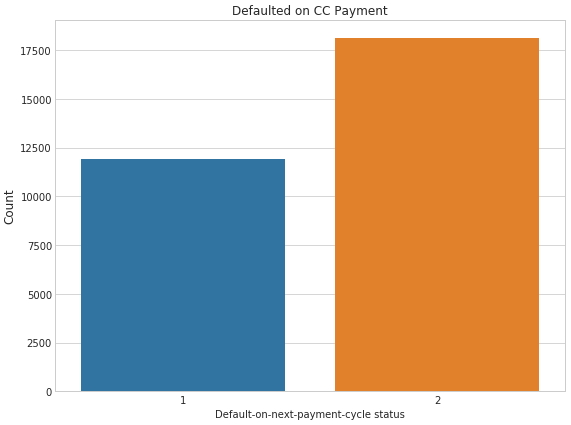

In [28]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.countplot(x='SEX', data=cc_raw, ax=ax)
    ax.set_ylabel('Count', fontsize=12)
#     ax.set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax.set_xlabel('Default-on-next-payment-cycle status')
    ax.set_title('Defaulted on CC Payment')
    plt.tight_layout()

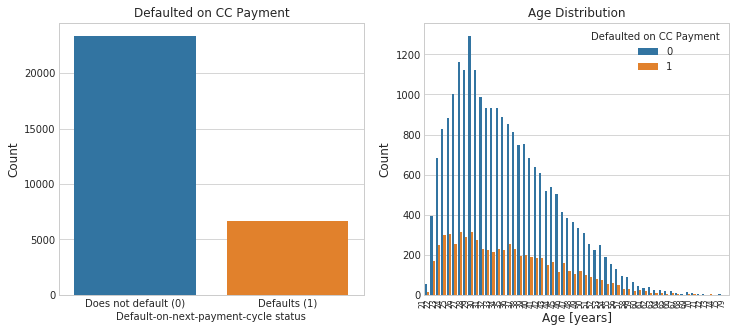

In [20]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
    sns.countplot(x='default_payment_next_month', data=cc_raw, ax=ax[0])
    ax[0].set_ylabel('Count', fontsize=12)
    ax[0].set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax[0].set_xlabel('Default-on-next-payment-cycle status')
    ax[0].set_title('Defaulted on CC Payment')
    sns.countplot(x='AGE', data=cc_raw, hue='default_payment_next_month', ax=ax[1])
    ax[1].set_xlabel('Age [years]', fontsize=12)
    ax[1].set_ylabel('Count', fontsize=12)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right', fontsize=7.5)
    ax[1].legend(loc='upper right', title='Defaulted on CC Payment')
    ax[1].set_title('Age Distribution')

<function matplotlib.pyplot.tight_layout>

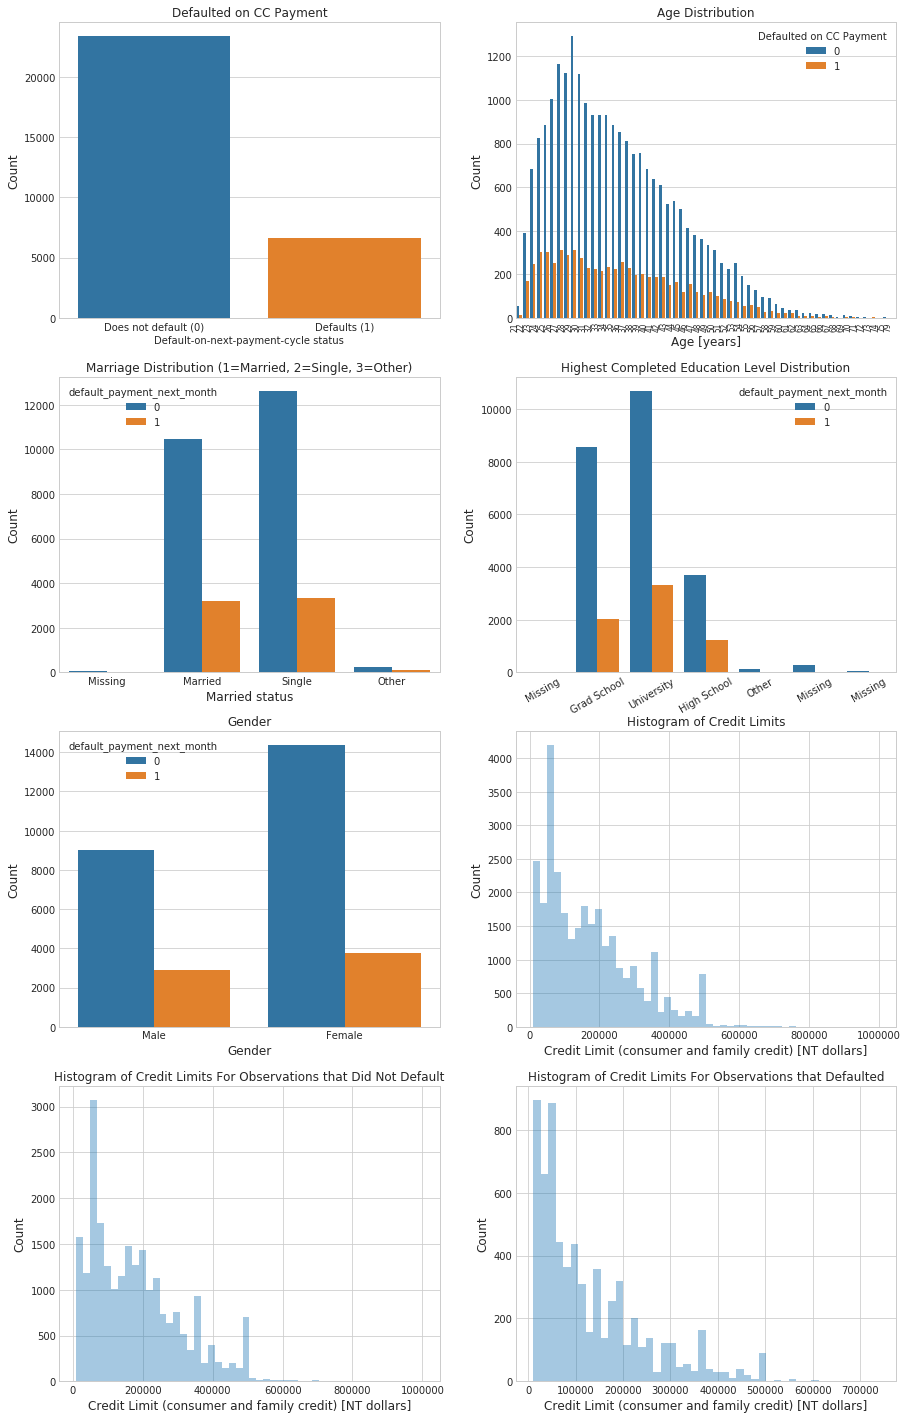

In [26]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(15,25))
    sns.countplot(x='default_payment_next_month', data=cc_raw, ax=ax[0,0])
    ax[0,0].set_ylabel('Count', fontsize=12)
    ax[0,0].set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax[0,0].set_xlabel('Default-on-next-payment-cycle status')
    ax[0,0].set_title('Defaulted on CC Payment')
    sns.countplot(x='AGE', data=cc_raw, hue='default_payment_next_month', ax=ax[0,1])
    ax[0,1].set_xlabel('Age [years]', fontsize=12)
    ax[0,1].set_ylabel('Count', fontsize=12)
    ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=90, ha='right', fontsize=7.5)
    ax[0,1].legend(loc='upper right', title='Defaulted on CC Payment')
    ax[0,1].set_title('Age Distribution')
    sns.countplot(x='MARRIAGE', data=cc_raw, hue='default_payment_next_month', ax=ax[1,0])
    ax[1,0].set_xlabel('Married status', fontsize=12)
    ax[1,0].set_xticklabels(['Missing', 'Married', 'Single', 'Other'])
    ax[1,0].set_ylabel('Count', fontsize=12)
    ax[1,0].set_title('Marriage Distribution (1=Married, 2=Single, 3=Other)')
    sns.countplot(x='EDUCATION', data=cc_raw, hue='default_payment_next_month', ax=ax[1,1])
    ax[1,1].set_xlabel('', fontsize=12)
    ax[1,1].set_xticklabels(['Missing','Grad School','University','High School','Other','Missing','Missing'],
                         rotation=30)
    ax[1,1].set_ylabel('Count', fontsize=12)
    ax[1,1].set_title('Highest Completed Education Level Distribution') 
    
    sns.countplot(x='SEX', data=cc_raw, hue='default_payment_next_month', ax=ax[2,0])
    ax[2,0].set_xlabel('Gender', fontsize=12)
    ax[2,0].set_xticklabels(['Male', 'Female'])
    ax[2,0].set_ylabel('Count', fontsize=12)
    ax[2,0].set_title('Gender')
    # Not including a number of bins, distplot uses the Freedman-Diaconis rule by default
    sns.distplot(cc_raw['LIMIT_BAL'], norm_hist=False, kde=False, ax=ax[2,1])
    ax[2,1].set_xlabel('Credit Limit (consumer and family credit) [NT dollars]', fontsize=12)
    ax[2,1].set_ylabel('Count', fontsize=12)
    ax[2,1].set_title('Histogram of Credit Limits')
    sns.distplot(cc_raw['LIMIT_BAL'][cc_raw['default_payment_next_month']==0], 
                 norm_hist=False, kde=False, ax=ax[3,0])
    ax[3,0].set_xlabel('Credit Limit (consumer and family credit) [NT dollars]', fontsize=12)
    ax[3,0].set_ylabel('Count', fontsize=12)
    ax[3,0].set_title('Histogram of Credit Limits For Observations that Did Not Default')
    sns.distplot(cc_raw['LIMIT_BAL'][cc_raw['default_payment_next_month']==1], 
                 norm_hist=False, kde=False, ax=ax[3,1])
    ax[3,1].set_xlabel('Credit Limit (consumer and family credit) [NT dollars]', fontsize=12)
    ax[3,1].set_ylabel('Count', fontsize=12)
    ax[3,1].set_title('Histogram of Credit Limits For Observations that Defaulted')
plt.tight_layout